# DDPG example

この例では，ChainerによるDDPGの実装と，OpenAI Gymへの適用を行います．DQNの例の説明を前提としています．

In [1]:
import copy
import random
import collections

import gym
import numpy as np
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import optimizers
%matplotlib notebook
import matplotlib.pyplot as plt

DQNと同様，DDPGでもニューラルネットによってQ関数を近似します．ただしDQNの場合と異なり，DDPGでは連続行動空間を扱います．そのため各行動の価値をそれぞれニューラルネットが出力するということはできず，代わりに状態表現と一緒に行動も入力に含めます．インタフェースは以下のようになります．

- 入力: 観測 + 行動 (ndim_obs + ndim_action 次元のベクトル)
- 出力: 価値 (スカラー)

In [2]:
class QFunction(chainer.Chain):

    def __init__(self, ndim_obs, ndim_action, n_hidden_channels=100):
        super(QFunction, self).__init__(
            l0=L.Linear(ndim_obs + ndim_action, n_hidden_channels),
            l1=L.Linear(n_hidden_channels, n_hidden_channels),
            l2=L.Linear(n_hidden_channels, 1, wscale=1e-3))

    def __call__(self, s, a):
        x = F.concat((s, a), axis=1)
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return self.l2(h)

DDPGではQ関数だけでなく方策も同様にニューラルネットによって表現します．特にDDPGは決定的な方策，すなわち状態が決まれば行動も決定的に決まる方策を用います．インタフェースは次のようになります．

- 入力: 観測 (ndim_obs次元のベクトル)
- 出力: 行動 (ndim_action次元のベクトル)

なお，多くのタスクでは行動がとれる値の範囲に制限があります．この例では，tanh関数でニューラルネットの出力を丸め，行動がその範囲に収まるようにしています．

In [3]:
def squash(x, high, low):
    center = (high + low) / 2
    scale = (high - low) / 2
    return F.tanh(x) * scale + center


class Policy(chainer.Chain):

    def __init__(self, ndim_obs, ndim_action, action_low, action_high,
                 n_hidden_channels=100):
        self.action_high = action_high
        self.action_low = action_low
        super(Policy, self).__init__(
            l0=L.Linear(ndim_obs, n_hidden_channels),
            l1=L.Linear(n_hidden_channels, n_hidden_channels),
            l2=L.Linear(n_hidden_channels, 1, wscale=1e-3))

    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return squash(self.l2(h),
                                 self.xp.asarray(self.action_high),
                                 self.xp.asarray(self.action_low))

上で定義した`Policy`を使って行動を1つ選ぶ関数`get_action`を実装しておきます．なお，`Policy`の出力は，それがGPU上にあるなら`cupy.ndarray`，CPU上にあるなら`numpy.ndarray`となりますが，OpenAI Gymの環境に渡す行動は`numpy.ndarray`でなければなりません．そのために，`chainer.cuda.to_cpu`という関数を使い常に`numpy.ndarray`を返すようにしておきます．

In [4]:
def get_action(policy, obs):
    xp = policy.xp
    obs = xp.expand_dims(xp.asarray(obs, dtype=np.float32), 0)
    with chainer.no_backprop_mode():
        a = policy(obs).data[0]
    return chainer.cuda.to_cpu(a)

`QFunction`と`Policy`のパラメータを更新する関数`update`を実装します．DQNと同様，それぞれのモデルに対してターゲットモデルが存在し，`Optimizer`も別々に用意します．

以下の式では方策を$\mu(s)$で表します．`QFunction`の更新式は，

$$Q(s,a) \leftarrow r + \gamma Q_{\text{target}}(s',\mu_\text{target}(s'))$$

となり，maxをとるのではなく方策$\mu_\text{target}$に従った行動の価値を目標値とするという点でDQNと異なります．

一方，`Policy`の更新式は，

$$\text{maximize}_\mu Q(s,\mu(s))$$

という形を取り，これは価値の符号を反転させたもの`-Q(s, policy(s))`を損失とみなせば損失最小化問題とみなすことができます．Chainerでこの損失について`backward`メソッドを呼ぶと，`Q`と`policy`それぞれのパラメータについて勾配が計算されますが，`opt_policy.update`によって更新されるのは`policy`のパラメータだけです．

In [5]:
def update(Q, target_Q, policy, target_policy, opt_Q, opt_policy,
           samples, gamma=0.99):
    n = len(samples)
    xp = Q.xp
    s = xp.asarray([sample[0] for sample in samples], dtype=np.float32)
    a = xp.asarray([sample[1] for sample in samples], dtype=np.float32)
    r = xp.asarray([sample[2] for sample in samples], dtype=np.float32)
    done = xp.asarray([sample[3] for sample in samples], dtype=np.float32)
    s_next = xp.asarray([sample[4] for sample in samples], dtype=np.float32)
    # Update Q
    y = F.reshape(Q(s, a), (n,))
    with chainer.no_backprop_mode():
        next_q = F.reshape(target_Q(s_next, target_policy(s_next)), (n,))
        t = r + gamma * (1 - done) * next_q
    loss = F.mean_squared_error(y, t)
    Q.cleargrads()
    loss.backward()
    opt_Q.update()
    # Update policy
    loss = - F.sum(Q(s, policy(s))) / n
    policy.cleargrads()
    loss.backward()
    opt_policy.update()

DQNのように一定周期でターゲットモデルを同期する代わりに，DDPGではターゲットモデルのパラメータを現在のモデルにゆっくり追随させていく方法が提案されています．次の`soft_copy_params`がこれを実装した関数です．Chainerでは`Link.params()`メソッドで特定の`Link`のパラメータを列挙することができるので，それを使ってターゲットモデルのパラメータを一定の割合$\tau$だけ現在のモデルに近づけていきます．

In [6]:
def soft_copy_params(source, target, tau):
    for s, t in zip(source.params(), target.params()):
        t.data[:] += tau * (s.data - t.data)

ここまでで必要な関数の実装は終わりました．以下ではアルゴリズムの全体を記述していきます．

In [7]:
# Hyperparameters
env_name = 'Pendulum-v0'
M = 1000
replay_start_size = 500
minibatch_size = 64
gpu = 0  # gpu id (-1 to use cpu)
tau = 1e-2  # degree of soft target update
reward_scale = 1e-3

# Initialize an environment
env = gym.make(env_name)
ndim_obs = env.observation_space.low.size
ndim_action = env.action_space.low.size

# Initialize variables
D = collections.deque(maxlen=10 ** 6)
Rs = []
step = 0

[2016-12-29 22:17:28,729] Making new env: Pendulum-v0


`QFunction`と`Policy`のインスタンスをそれぞれ作成し，ターゲットモデルと`Optimizer`もそれぞれ用意します．

In [8]:
# Initialize chainer models
Q = QFunction(ndim_obs, ndim_action)
policy = Policy(ndim_obs, ndim_action,
                env.action_space.low, env.action_space.high)
if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    Q.to_gpu(gpu)
    policy.to_gpu(gpu)
target_Q = copy.deepcopy(Q)
target_policy = copy.deepcopy(policy)
opt_Q = optimizers.Adam()
opt_Q.setup(Q)
opt_policy = optimizers.Adam(alpha=1e-4)
opt_policy.setup(policy)

以下がアルゴリズムの本体にあたります．環境とのインタラクションのループを回しつつ，経験をreplay memoryに蓄積していき，そこからのサンプルにより`Q`および`policy`を更新していきます．環境とのインタラクションの際には，行動にガウシアンノイズを加えることによってexplorationを行っています．

可視化のために各エピソードごとのスコア（報酬の和）を記録しプロットおり，学習の進行度合いを確認することができます．

<IPython.core.display.Javascript object>


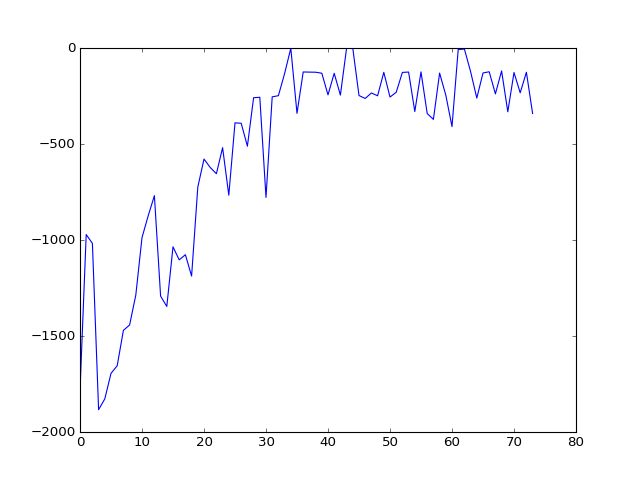

episode: 0 step: 875 R:-1883.68961728 average_R:-1414.53624458
episode: 1 step: 1075 R:-1827.52075804 average_R:-1497.13314727
episode: 2 step: 1275 R:-1694.69723411 average_R:-1530.06049508
episode: 3 step: 1475 R:-1654.72818389 average_R:-1547.87016491
episode: 4 step: 1675 R:-1470.57947643 average_R:-1538.20882885
episode: 5 step: 1875 R:-1442.68301208 average_R:-1527.59484921
episode: 6 step: 2075 R:-1286.78379761 average_R:-1503.51374405
episode: 7 step: 2275 R:-987.747954959 average_R:-1456.62594504
episode: 8 step: 2475 R:-873.571437247 average_R:-1408.03806939
episode: 9 step: 2675 R:-768.936546461 average_R:-1358.87641378
episode: 10 step: 2875 R:-1292.20270469 average_R:-1354.11400599
episode: 11 step: 3075 R:-1346.0924731 average_R:-1353.57923713
episode: 12 step: 3275 R:-1035.58234021 average_R:-1333.70443107
episode: 13 step: 3475 R:-1103.38476398 average_R:-1320.15621536
episode: 14 step: 3675 R:-1076.64630503 average_R:-1306.62788701
episode: 15 step: 3875 R:-1187.916805

In [ ]:
# Initialize a figure
fig, ax = plt.subplots(1,1)

for episode in range(M):

    obs = env.reset()
    done = False
    R = 0.0
    t = 0

    while not done and t < env.spec.timestep_limit:

        # Select an action
        a = get_action(policy, obs) + np.random.normal(scale=0.4)

        # Execute an action
        new_obs, r, done, _ = env.step(a)
        # env.render(mode='rgb_array')
        env.render()
        R += r

        # Store a transition
        D.append((obs, a, r * reward_scale, done, new_obs))
        obs = new_obs

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            samples = random.sample(D, minibatch_size)
            update(Q, target_Q, policy, target_policy,
                   opt_Q, opt_policy, samples)

        # Soft update of target models
        soft_copy_params(Q, target_Q, tau)
        soft_copy_params(policy, target_policy, tau)

        step += 1
        t += 1

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    print('episode: {} step: {} R:{} average_R:{}'.format(
          episode, step, R, average_R))
    ax.clear()
    ax.plot(Rs)
    fig.canvas.draw()